# Remove RBCs and small cells

#### This notebook removes the RBCs identified via feature extraction/clustering, as well as cells too small to be real

In [1]:
import json
import numpy as np
from PIL import  Image
import io
import base64
import zlib
import cv2
from string import Template
import glob
import os
import tifffile
import math
from skimage import data, segmentation, util, measure
import pandas as pd
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt

## Obtain area of each cell in pixels

In [2]:
patients = ['P51', 'P52', 'P53', 'P56', 'P57', 'P58']

In [3]:
all_pts_dfs = []

for patient in patients:

    # loop through all mask files to get size of each cell
    mask_dir = '/data/Zhaolab/1_AMLCosMx/Final_scripts/2_Segmentation/3_NucMemMerging/' + patient + '_hybrid/labels_predicted_2_15_24/'
    masks = [f for f in listdir(mask_dir) if isfile(join(mask_dir, f))]
    masks.sort()

    all_fov_dfs = []

    for i in range(len(masks)):

        name = masks[i].replace('_normalized_cp_masks.tif', '')
        fov = int(name[-2:])
        # Read image and mask
        mask = tifffile.imread(mask_dir + masks[i])

        # Find centroid and area of each cell
        label_image = mask.astype(int)
        props = measure.regionprops_table(label_image,
                                   properties=['label', 'area', 'centroid'])
        data = pd.DataFrame(props)
        data = data.rename(columns={"centroid-0": "y", "centroid-1": "x"}) # this was corrected
        data['Patient'] = patient
        data['FOV'] = fov
        data['ID'] = data['Patient'] + '_FOV' + data['FOV'].astype(str).str.zfill(2) + '_cell_' + data['label'].astype(str)

        all_fov_dfs.append(data)

    # combine all cell size DFs from given patient    
    AllPt_cells = pd.concat(all_fov_dfs)
    AllPt_cells = AllPt_cells.set_index('ID')

    # read in RBC labels from all 3 timepoints
    tba = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/1_IdentifyRBCs_2channel/' + patient + '/TPA/' + patient + 'A_RBCs.csv')
    tbb = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/1_IdentifyRBCs_2channel/' + patient + '/TPB/' + patient + 'B_RBCs.csv')
    tbc = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/1_IdentifyRBCs_2channel/' + patient + '/TPC/' + patient + 'C_RBCs.csv')
    rbcs = pd.concat([tba, tbb, tbc], ignore_index=True)

    # give each cell unique ID, set as index
    rbcs['ID'] = rbcs['Patient'] + '_FOV' + rbcs['FOV'].astype(str).str.zfill(2) + '_cell_' + rbcs['cell_ID'].astype(str)
    rbcs = rbcs.set_index('ID')

    # add column to identify all cells as RBCs
    rbcs['RBC'] = 1

    # merge RBC DF with all cell DF (0 means not RBC, 1 means RBC)
    AllPt_cells = AllPt_cells.merge(rbcs['RBC'], how='left', left_index=True, right_index=True)
    AllPt_cells['RBC'] = AllPt_cells['RBC'].fillna(0)
    AllPt_cells['RBC'] = AllPt_cells['RBC'].astype(int)
    
    # save single patient output to list
    all_pts_dfs.append(AllPt_cells)

In [4]:
# concatenate into one table for all patients
all_pt_data = pd.concat(all_pts_dfs)
all_pt_data

,label,area,y,x,Patient,FOV,RBC
ID,,,,,,,
P51_FOV01_cell_1,1,903,15.766334,74.070875,P51,1,0
P51_FOV01_cell_2,2,1122,14.835116,117.772727,P51,1,0
P51_FOV01_cell_3,3,2034,20.265487,218.211898,P51,1,0
P51_FOV01_cell_4,4,2534,41.141279,962.670481,P51,1,0
P51_FOV01_cell_5,5,1006,16.085487,1059.072565,P51,1,0
...,...,...,...,...,...,...,...
P58_FOV23_cell_7971,7971,596,3640.771812,4117.850671,P58,23,0
P58_FOV23_cell_7972,7972,359,3641.122563,4992.493036,P58,23,0
P58_FOV23_cell_7973,7973,188,3642.707447,3546.191489,P58,23,0


In [9]:
# save entire DF before RBC removal
#all_pt_data.to_csv('All_cells_RBCs_IDed.csv')

In [7]:
# export list of RBCs to remove
RBCs = all_pt_data[all_pt_data['RBC'] == 1]
RBCs.to_csv('RBCs_to_remove.csv')

In [8]:
# remove RBCs
noRBCs = all_pt_data[all_pt_data['RBC'] == 0]
noRBCs

,label,area,y,x,Patient,FOV,RBC
ID,,,,,,,
P51_FOV01_cell_1,1,903,15.766334,74.070875,P51,1,0
P51_FOV01_cell_2,2,1122,14.835116,117.772727,P51,1,0
P51_FOV01_cell_3,3,2034,20.265487,218.211898,P51,1,0
P51_FOV01_cell_4,4,2534,41.141279,962.670481,P51,1,0
P51_FOV01_cell_5,5,1006,16.085487,1059.072565,P51,1,0
...,...,...,...,...,...,...,...
P58_FOV23_cell_7971,7971,596,3640.771812,4117.850671,P58,23,0
P58_FOV23_cell_7972,7972,359,3641.122563,4992.493036,P58,23,0
P58_FOV23_cell_7973,7973,188,3642.707447,3546.191489,P58,23,0


<AxesSubplot:>

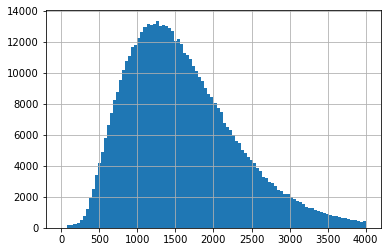

In [9]:
noRBCs['area'].hist(bins=100, range=(0,4000))

In [10]:
small_cells = noRBCs[noRBCs['area'] <= 250]
small_cells

,label,area,y,x,Patient,FOV,RBC
ID,,,,,,,
P51_FOV01_cell_15,15,96,5.489583,4538.427083,P51,1,0
P51_FOV01_cell_1253,1253,222,3569.067568,4406.617117,P51,1,0
P51_FOV01_cell_2384,2384,81,2044.000000,4361.000000,P51,1,0
P51_FOV02_cell_3970,3970,189,2844.243386,3144.275132,P51,2,0
P51_FOV03_cell_1917,1917,219,2253.803653,2763.547945,P51,3,0
...,...,...,...,...,...,...,...
P58_FOV23_cell_7334,7334,103,2975.000000,4532.000000,P58,23,0
P58_FOV23_cell_7364,7364,241,3028.937759,4697.195021,P58,23,0
P58_FOV23_cell_7586,7586,233,3229.914163,5269.600858,P58,23,0


In [11]:
# export list of small cells to remove
small_cells.to_csv('smallcells_to_remove.csv')

### View smallest cells to determine appropriate cutoff

In [44]:
# create dictionary of directories for each patient
img_dirs = {'P51':'/data/Zhaolab/1_AMLCosMx/Final_scripts/1_Normalization/0_NormalizedImg/P51_R1158_S1_Normalized/', 
            'P52':'/data/Zhaolab/1_AMLCosMx/Final_scripts/1_Normalization/0_NormalizedImg/P52_R1149_S1_Normalized/', 
            'P53':'/data/Zhaolab/1_AMLCosMx/Final_scripts/1_Normalization/0_NormalizedImg/P53_R1149_S2_Normalized/', 
            'P56':'/data/Zhaolab/1_AMLCosMx/Final_scripts/1_Normalization/0_NormalizedImg/P56_R1158_S2_Normalized/', 
            'P57':'/data/Zhaolab/1_AMLCosMx/Final_scripts/1_Normalization/0_NormalizedImg/P57_R1158_S3_Normalized/', 
            'P58':'/data/Zhaolab/1_AMLCosMx/Final_scripts/1_Normalization/0_NormalizedImg/P58_R1149_S3_Normalized/'}

In [45]:
patient = 'P58'

# subset small cell table to this patient
one_pt = small_cells[small_cells['Patient'] == patient]

# create dictionary of directories for each patient
mask_dir = '/data/Zhaolab/1_AMLCosMx/Final_scripts/2_Segmentation/3_NucMemMerging/' + patient + '_hybrid/labels_predicted_2_15_24/'

In [46]:
# create list of fovs
fovs = list(set(one_pt['FOV'].tolist()))
fovs.sort()
    
for fov in fovs:
    
    # subset FOV        
    one_fov = one_pt[one_pt['FOV'] == fov]
    
    # Load img
    location = img_dirs[patient]
    dirlist = listdir(location)
    dirlist.sort()
    for item in dirlist:
        if 'F0' + str(fov).zfill(2) in item:
            img = cv2.imread(location + item)
            print(item)
            break
            
    # brighten image
    # define the alpha and beta
    alpha = 1.5 # Contrast control
    beta = 20 # Brightness control

    # call convertScaleAbs function
    img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    # Load masks
    location = mask_dir
    dirlist = listdir(location)
    dirlist.sort()
    for item in dirlist:
        if 'F0' + str(fov).zfill(2) in item:
            labels = tifffile.imread(location + item)
            print(item)
            break
        elif 'FOV' + str(fov).zfill(2) in item:
            labels = tifffile.imread(location + item)
            print(item)
            break

    # get all mask values
    fov_cells = np.unique(labels)
    
    # create list of small cells
    pos_cells = one_fov['label'].tolist()
    pos_cells = [int(i) for i in pos_cells]
    # set all labels of other clusters to zero
    labels_edited = labels.copy()
    for cell in fov_cells:
        if cell in pos_cells:
            pass
        else:
            labels_edited[labels_edited == cell] = 0

    # add colored outline
    boundaries = segmentation.find_boundaries(labels_edited, connectivity=1, mode='thick', background=0)
    boundaries = boundaries.astype(int)
    img[boundaries>0] = [0,0,255]
            
    # save image
    cv2.imwrite('size_check/' + patient + '_FOV' + str(fov).zfill(2) + '.png', img)

20220215_094003_S3_C902_P99_N99_F001_normalized.png
20220215_094003_S3_C902_P99_N99_F001_normalized_cp_masks.tif
20220215_094003_S3_C902_P99_N99_F002_normalized.png
20220215_094003_S3_C902_P99_N99_F002_normalized_cp_masks.tif
20220215_094003_S3_C902_P99_N99_F003_normalized.png
20220215_094003_S3_C902_P99_N99_F003_normalized_cp_masks.tif


KeyboardInterrupt: 

### Only keep cells larger than 250 pixels in area

In [13]:
cells_to_keep = noRBCs[noRBCs['area'] > 250]
cells_to_keep

,label,area,y,x,Patient,FOV,RBC
ID,,,,,,,
P51_FOV01_cell_1,1,903,15.766334,74.070875,P51,1,0
P51_FOV01_cell_2,2,1122,14.835116,117.772727,P51,1,0
P51_FOV01_cell_3,3,2034,20.265487,218.211898,P51,1,0
P51_FOV01_cell_4,4,2534,41.141279,962.670481,P51,1,0
P51_FOV01_cell_5,5,1006,16.085487,1059.072565,P51,1,0
...,...,...,...,...,...,...,...
P58_FOV23_cell_7966,7966,731,3638.218878,4327.127223,P58,23,0
P58_FOV23_cell_7971,7971,596,3640.771812,4117.850671,P58,23,0
P58_FOV23_cell_7972,7972,359,3641.122563,4992.493036,P58,23,0


In [48]:
cells_to_keep.to_csv('Cells_filtbyRBCandsize.csv')

In [14]:
# ensure total number of original cells equals sum of cells to keep, small cells, and RBCs
cells_to_keep.shape[0] + small_cells.shape[0] + RBCs.shape[0]

630206